In [3]:
import torch as tc
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
from data_set_.data_loader_ import ISITDataset,make_df_from_data_dir
from nets.nn_net import NeuralNetwork
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
device = tc.device("cuda" if tc.cuda.is_available() else "cpu")

In [5]:
print(device)

cuda


In [4]:
train_data_ratio = 0.8
df_dict_all,df_dict_train,df_dict_eval = make_df_from_data_dir(train_data_ratio = train_data_ratio)

./data/isit-2024-bits-and-bots/ISIT_Dataset/hlisa_traces
./data/isit-2024-bits-and-bots/ISIT_Dataset/gremlins
./data/isit-2024-bits-and-bots/ISIT_Dataset/za_proxy
./data/isit-2024-bits-and-bots/ISIT_Dataset/survey_desktop
./data/isit-2024-bits-and-bots/ISIT_Dataset/random_mouse_with_sleep_bot
hlisa_traces
gremlins
za_proxy
survey_desktop
random_mouse_with_sleep_bot
hlisa_traces Index(['userId', 'x', 'y', 'eventName', 'userType', 'time_diff'], dtype='object') 398788
unique user 1166 / 398788
gremlins Index(['userId', 'x', 'y', 'eventName', 'userType', 'time_diff'], dtype='object') 185657
unique user 577 / 185657
za_proxy Index(['userId', 'x', 'y', 'eventName', 'userType', 'time_diff'], dtype='object') 46426
unique user 853 / 46426
survey_desktop Index(['userId', 'x', 'y', 'eventName', 'userType', 'time_diff'], dtype='object') 650641
unique user 64743 / 650641
random_mouse_with_sleep_bot Index(['userId', 'x', 'y', 'eventName', 'userType', 'time_diff'], dtype='object') 183365
unique user 

In [6]:
max_sample_len_train = 70
min_sample_len_train = 1
training_len  = 1000
eval_len = 10
batch_size = 128
train_dataset = ISITDataset(df_dict_train,training_len=training_len*batch_size,
                            min_sample_len=min_sample_len_train,
                            max_sample_len=max_sample_len_train)   
eval_dataset  = ISITDataset(df_dict_eval,training_len=eval_len*batch_size,
                            min_sample_len=max_sample_len_train,
                            max_sample_len=max_sample_len_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=True)
idx = 0
category = len(train_dataset.idx_2_name)  #5 #['hlisa_traces', 'gremlins', 'za_proxy', 'survey_desktop', 'random_mouse_with_sleep_bot']
model = NeuralNetwork(max_len=max_sample_len_train,output_size=category).to(device)
criterion = nn.CrossEntropyLoss()  # sigma [ y log(y_hat) ]
learning_rate = 1e-4
# optimizer = tc.optim.Adam(model.parameters(),lr=learning_rate)
optimizer = tc.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)

In [8]:
# calculate confusion metrics
def cal_metrics(pred, ans):
    # Convert tensors to numpy arrays
    # pred_np = pred.numpy()
    # ans_np = ans.numpy()
    if pred.get_device() != 'cpu':
        pred_np = pred.detach().cpu().numpy()
    if ans.get_device() != 'cpu':
        ans_np = ans.detach().cpu().numpy()
    # Calculate metrics
    accuracy = accuracy_score(pred_np, ans_np)
    f1 = f1_score(pred_np, ans_np, average='weighted')
    recall = recall_score(pred_np, ans_np, average='weighted')
    precision = precision_score(pred_np, ans_np, average='weighted')

    return accuracy, f1, recall, precision

In [9]:
scheduler_types = ['StepLR',                      #0
                   'MultiStepLR',                 #1
                   'CosineAnnealingWarmRestarts', #2
                   'ReduceLROnPlateau',           #3
                   'LambdaLR',                    #4
                   'ConstantLR',                  #5
                   'LinearLR',                    #6
                   'ExponentialLR',               #7
                   'CosineAnnealingLR',           #8
                   'MultiplicativeLR']            #9
scheduler_type = scheduler_types[3]

if scheduler_type == 'StepLR':
    scheduler = tc.optim.lr_scheduler.StepLR(optimizer, step_size=num_train_steps, gamma=0.1, last_epoch=-1, verbose='deprecated')
if scheduler_type == 'MultiStepLR':
    scheduler = tc.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,4,6,8], gamma=0.1)
if scheduler_type == 'CosineAnnealingWarmRestarts':
    scheduler = tc.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=3, T_mult=1, eta_min=0, last_epoch=-1, verbose='deprecated')
if scheduler_type == 'ReduceLROnPlateau':
    scheduler = tc.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose='deprecated')
if scheduler_type == 'LambdaLR':
    # Define lr_lambda as a function
    lr_lambda = lambda epoch: 0.95 ** epoch
    scheduler = tc.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda, last_epoch=-1)
if scheduler_type == 'ConstantLR':
    scheduler = tc.optim.lr_scheduler.ConstantLR(optimizer, factor=0.3333333333333333, total_iters=5, last_epoch=-1, verbose='deprecated')
if scheduler_type =='LinearLR':
    scheduler = tc.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.3333333333333333, end_factor=1.0, total_iters=5, last_epoch=-1, verbose='deprecated')
if scheduler_type == 'ExponentialLR':
    scheduler = tc.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, last_epoch=-1, verbose='deprecated')
if scheduler_type == 'CosineAnnealingLR':
    scheduler = tc.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = parameters['epoch'], eta_min=0, last_epoch=-1, verbose='deprecated')
if scheduler_type == 'MultiplicativeLR':
    scheduler = tc.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda = 0.95, last_epoch=-1, verbose='deprecated')

In [12]:
# Training loop
# Use Training set for ISIT2024
idx = 0
# training_len = len(train_loader)
num_epochs = 10
max_sample_len_train = 70
min_sample_len_train = 1
training_len  = 1000
eval_len = 10
batch_size = 128

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        _, time_diff, pos_x, pos_y, _, terminate_idx, userType = batch
        time_diff = time_diff.to(device)
        pos_x = pos_x.to(device)
        pos_y = pos_y.to(device)
        terminate_idx = terminate_idx.to(device)
        userType = userType.to(device)
        y_target = userType
        y_hat = model(time_diff, pos_x, pos_y, terminate_idx)
        loss = criterion(y_hat, y_target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        idx += 1
        print(f"{idx}/{training_len * num_epochs}, term_idx {terminate_idx[0].item()}, {loss.item()=}")
        assert min_sample_len_train <= terminate_idx[0].item() <= max_sample_len_train
        running_loss += loss.item()

    # Step the scheduler
    if scheduler_type == 'ReduceLROnPlateau':
        scheduler.step(running_loss)
    else:
        scheduler.step()

1/10000, term_idx 2, loss.item()=0.2835921049118042
2/10000, term_idx 26, loss.item()=0.330417662858963
3/10000, term_idx 22, loss.item()=0.251641184091568
4/10000, term_idx 29, loss.item()=0.20862746238708496
5/10000, term_idx 31, loss.item()=0.50895756483078
6/10000, term_idx 60, loss.item()=0.3092157244682312
7/10000, term_idx 8, loss.item()=0.42197147011756897
8/10000, term_idx 29, loss.item()=0.3649301826953888
9/10000, term_idx 3, loss.item()=0.395598441362381
10/10000, term_idx 36, loss.item()=0.24279215931892395
11/10000, term_idx 64, loss.item()=0.35254907608032227
12/10000, term_idx 51, loss.item()=0.32501116394996643
13/10000, term_idx 20, loss.item()=0.3748794496059418
14/10000, term_idx 63, loss.item()=0.26525986194610596
15/10000, term_idx 27, loss.item()=0.41275307536125183
16/10000, term_idx 57, loss.item()=0.3051243722438812
17/10000, term_idx 10, loss.item()=0.3993435800075531
18/10000, term_idx 66, loss.item()=0.37630313634872437
19/10000, term_idx 13, loss.item()=0.

KeyboardInterrupt: 

In [9]:
len(train_dataloader)

1000

## 學長的

In [ ]:
num_correct = 0
num_samples = 0

x_axis_len = 5
n_to_detect_list = np.linspace(1,max_sample_len_train,x_axis_len).astype(int)  #[1,18,35,52,70]
y_correct_list = np.zeros(x_axis_len)
test_i = 0
for batch in eval_dataloader:
  _, time_diff, pos_x, pos_y, _,terminate_idx, userType = batch
  ##time_diff() pos_x (128,70)=(bs,n_of_events)
  time_diff = time_diff.to(device)
  pos_x = pos_x.to(device)
  pos_y = pos_y.to(device)
  terminate_idx =terminate_idx.to(device)
  userType = userType.to(device)
  y_target = userType   
  assert tc.all(terminate_idx == max_sample_len_train).cpu()
  for i in range(x_axis_len):
    pos_x2 = pos_x.clone()
    pos_y2 = pos_y.clone()
    time_diff2 =time_diff.clone()
    stop_idx = n_to_detect_list[i]
    if i != (x_axis_len-1):
      pos_x2[:,stop_idx:] = 0 
      pos_y2[:,stop_idx:] = 0 
      time_diff2[:,stop_idx:] = 0 
    y_hat = model(time_diff2,pos_x2,pos_y2,terminate_idx)
    _, predictions = y_hat.max(1)
    y_correct_list[i] += (predictions == y_target).sum()
  num_correct += (predictions == y_target).sum()
  num_samples += predictions.size(0)
  test_i+=1
  print(f"{test_i}/{eval_len}___")
assert num_samples == test_i * batch_size
y_correct_list /= test_i * batch_size
print(f"Accuracy on test set: {num_correct/num_samples*100:.2f}")
print(f"{y_correct_list*100}")

## 我的

In [10]:
# Assuming you have a DataLoader for evaluation
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

num_correct = 0
num_samples = 0

x_axis_len = 5
n_to_detect_list = np.linspace(1, max_sample_len_train, x_axis_len).astype(int)  #[1,18,35,52,70]
y_correct_list = np.zeros(x_axis_len)
test_i = 0

all_preds = []
all_labels = []

for batch in eval_dataloader:
    _, time_diff, pos_x, pos_y, _, terminate_idx, userType = batch
    time_diff = time_diff.to(device)
    pos_x = pos_x.to(device)
    pos_y = pos_y.to(device)
    terminate_idx = terminate_idx.to(device)
    userType = userType.to(device)
    y_target = userType   
    assert tc.all(terminate_idx == max_sample_len_train).cpu()
    
    for i in range(x_axis_len):
        pos_x2 = pos_x.clone()
        pos_y2 = pos_y.clone()
        time_diff2 = time_diff.clone()
        stop_idx = n_to_detect_list[i]
        if i != (x_axis_len - 1):
            pos_x2[:, stop_idx:] = 0 
            pos_y2[:, stop_idx:] = 0 
            time_diff2[:, stop_idx:] = 0 
        y_hat = model(time_diff2, pos_x2, pos_y2, terminate_idx)
        _, predictions = y_hat.max(1)
        y_correct_list[i] += (predictions == y_target).sum().item()
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(y_target.cpu().numpy())
        
    num_correct += (predictions == y_target).sum().item()
    num_samples += predictions.size(0)
    test_i += 1
    print(f"{test_i}/{len(eval_dataloader)}___")

assert num_samples == test_i * eval_dataloader.batch_size

# Calculate overall accuracy
overall_accuracy = num_correct / num_samples * 100
print(f"Accuracy on test set: {overall_accuracy:.2f}%")

# Calculate detailed metrics using cal_metrics
accuracy, f1, recall, precision = cal_metrics(tc.tensor(all_preds), tc.tensor(all_labels))
print(f"Evaluation - Accuracy: {accuracy}, F1 Score: {f1}, Recall: {recall}, Precision: {precision}")

# Calculate accuracy per detection length
y_correct_list /= num_samples
print(f"Accuracy per detection length: {y_correct_list * 100}")

1/10___
2/10___
3/10___
4/10___
5/10___
6/10___
7/10___
8/10___
9/10___
10/10___
Accuracy on test set: 97.66%
Evaluation - Accuracy: 0.91625, F1 Score: 0.917004454413399, Recall: 0.91625, Precision: 0.9195724759505142
Accuracy per detection length: [71.484375 94.375    97.265625 97.34375  97.65625 ]


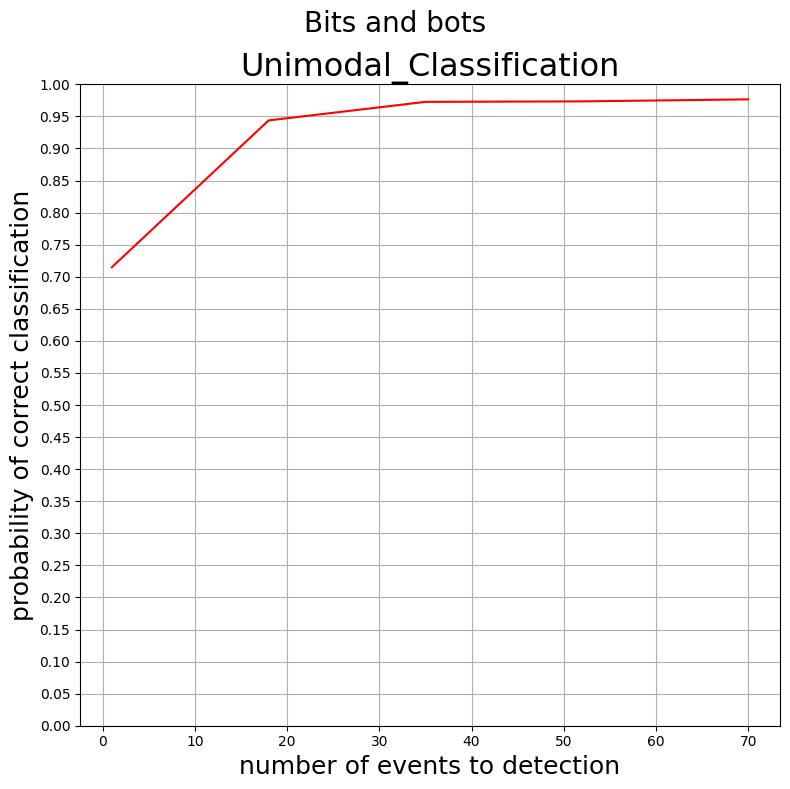

In [11]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
fig.suptitle('Bits and bots', fontsize=20)
title = "Unimodal_Classification"
ax.set_title(title,fontsize=23)
ax.set_ylabel('probability of correct classification',fontsize =18)
ax.set_xlabel('number of events to detection',fontsize =18)
ax.set_ylim([0, 1])
plt.yticks(np.arange(0, 1+0.05, 0.05))
plt.grid(True)
ax.plot(n_to_detect_list,y_correct_list,'r',label="relu")


plt.tight_layout() 
plt.savefig(f"result_{title}_{training_len=}.png")
plt.show()
breakpoint()

In [25]:
# Calculate false positive rate
def cal_false_positive_rate(pred, ans, positive_label=1):
    # Convert tensors to numpy arrays if necessary
    if isinstance(pred, tc.Tensor):
        pred = pred.cpu().numpy()
    if isinstance(ans, tc.Tensor):
        ans = ans.cpu().numpy()
    # Calculate false positives and total negatives
    false_positives = np.sum((pred == positive_label) & (ans != positive_label))
    total_negatives = np.sum(ans != positive_label)
    # False positive rate
    fpr = false_positives / total_negatives if total_negatives > 0 else 0
    return fpr

ValueError: x and y must be the same size

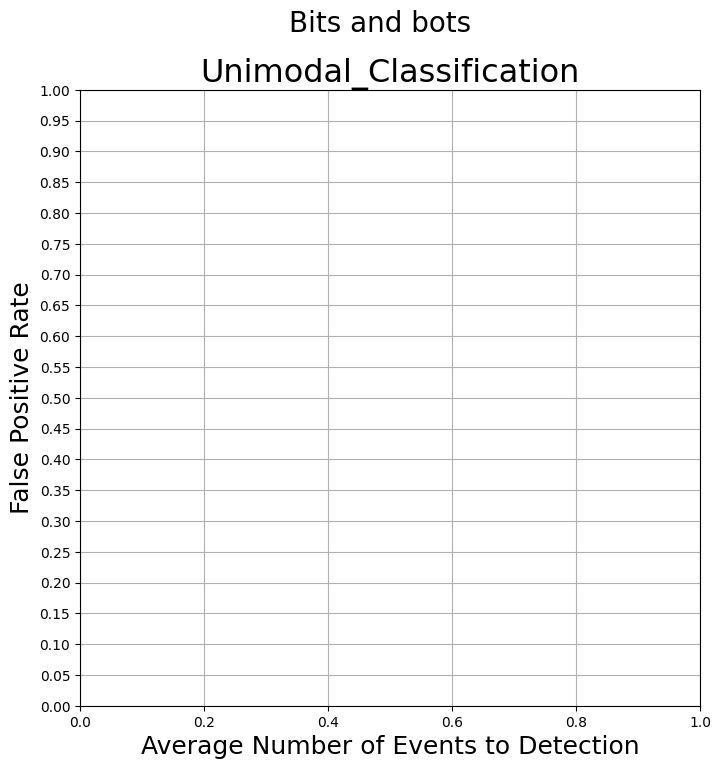

In [26]:
# Calculate false positive rate for each detection length
false_positive_rates = np.zeros(x_axis_len)
for i in range(x_axis_len):
    pos_x2 = pos_x.clone()
    pos_y2 = pos_y.clone()
    time_diff2 = time_diff.clone()
    stop_idx = n_to_detect_list[i]
    if i != (x_axis_len - 1):
        pos_x2[:, stop_idx:] = 0 
        pos_y2[:, stop_idx:] = 0 
        time_diff2[:, stop_idx:] = 0 
    y_hat = model(time_diff2, pos_x2, pos_y2, terminate_idx)
    _, predictions = y_hat.max(1)
    false_positive_rates[i] = cal_false_positive_rate(predictions, y_target, positive_label=1) # Assuming class '1' is the automated agent class

# Average number of events to detection
avg_times = np.mean(n_to_detect_list)

# Plotting the false positive rate
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
fig.suptitle('Bits and bots', fontsize=20)
title = "Unimodal_Classification"
ax.set_title(title, fontsize=23)
ax.set_ylabel('False Positive Rate', fontsize=18)
ax.set_xlabel('Average Number of Events to Detection', fontsize=18)
ax.set_ylim([0, 1])
plt.yticks(np.arange(0, 1 + 0.05, 0.05))
plt.grid(True)
ax.scatter(avg_times, false_positive_rates, color='blue', label="False Positive Rate")

plt.tight_layout()
plt.savefig(f"fpr_result_{title}_{training_len=}.png")
plt.show()